# Kendrick Lamar Lyrics Generator using Markov Chains

Markov chain model to generate new lyrics in the style of Kendrick Lamar based on his existing lyrics.

In [14]:
import os
import sys
import random
import re
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Loading and preprocessing lyrics data

In [15]:
def load_lyrics_from_csv(filepath):
    try:
        df = pd.read_csv(filepath)
        lyrics = df['lyrics'].dropna().astype(str).tolist()
        return lyrics
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return []


csv_path = "../data/cleaned_lyrics.csv"
if os.path.exists(csv_path):
    print(f"Loading lyrics from CSV: {csv_path}")
    lyrics_data = load_lyrics_from_csv(csv_path)
    print(f"Loaded {len(lyrics_data)} lyrics from CSV")
else:
    print("No lyrics data found. Please provide valid file paths.")
    lyrics_data = []

Loading lyrics from CSV: ../data/cleaned_lyrics.csv
Loaded 102 lyrics from CSV


## Preprocessing the lyrics

In [16]:
def preprocess_lyrics(lyrics_list):
    processed_lyrics = []
    
    for lyrics in lyrics_list:
        # Convert to lowercase
        lyrics = lyrics.lower()
        
        # Remove special characters but keep sentence punctuation
        lyrics = re.sub(r'[^\w\s.,!?\()" -]+', '', lyrics)
        
        # Split into sentences
        sentences = re.split(r'(?<=[.!?])\s+', lyrics)
        
        # Filter out empty sentences
        sentences = [s.strip() for s in sentences if s.strip()]
        
        processed_lyrics.extend(sentences)
    
    return processed_lyrics


if lyrics_data:
    processed_lyrics = preprocess_lyrics(lyrics_data)
    print(f"Processed {len(processed_lyrics)} sentences from the lyrics")
else:
    print("No lyrics data found.")
    processed_lyrics = []

Processed 907 sentences from the lyrics


## Implementing the Markov Chain Model

In [17]:
class MarkovModel:
    def __init__(self, order=2):
        self.order = order
        self.model = defaultdict(list)
        self.starts = []
        
    def train(self, sentences):
        for sentence in sentences:
            words = re.findall(r'\b\w+\b|[.!?,]', sentence.lower())
            
            if len(words) <= self.order:
                continue # this means sentence would be too short for training, not useful
                
            # Possible starting points for sentence generation
            self.starts.append(tuple(words[:self.order]))
            
            # Build the model
            for i in range(len(words) - self.order):
                context = tuple(words[i:i+self.order])
                next_word = words[i+self.order]
                self.model[context].append(next_word)
                
    def generate(self, seed_words=None, max_length=50):

        if not self.model:
            return "Model has not been trained yet."
            
        # Start with given seed or random start
        if seed_words and len(seed_words) >= self.order:
            current = tuple(seed_words[-self.order:])
            result = seed_words.copy()
        else:
            if not self.starts:
                return "Cannot generate text: no sentence starts found."
            current = random.choice(self.starts)
            result = list(current)
        
        # Generate words
        while len(result) < max_length:
            if current not in self.model:
                # If we hit a context not in our model, try to recover
                if len(result) >= self.order:
                    # Try to form a new context from the last words
                    current = tuple(result[-self.order:])
                    if current not in self.model:
                        break
                else:
                    break
            
            next_word = random.choice(self.model[current])
            result.append(next_word)
            
            # Update the context window
            current = tuple(result[-self.order:])
            
            # End if we reach sentence-ending punctuation
            if next_word in ['.', '!', '?'] and len(result) > max_length // 2:
                break
                
        # Format the result nicely
        formatted = []
        for i, word in enumerate(result):
            if word in [',', '.', '!', '?']:
                formatted[-1] += word
            elif i > 0 and result[i-1] not in [',', '.', '!', '?']:
                formatted.append(word)
            else:
                formatted.append(word)
                
        return ' '.join(formatted)

# Train the model with different orders
if processed_lyrics:
    # Create models with different orders
    models = {}
    for order in [1, 2, 3, 4, 5]:
        print(f"\nTraining Markov model with order {order}...")
        model = MarkovModel(order=order)
        model.train(processed_lyrics)
        models[order] = model
        print(f"Model trained with {len(model.model)} contexts")
    

    markov_model = models[1]
else:
    print("No lyrics data to train the model.")


Training Markov model with order 1...
Model trained with 6790 contexts

Training Markov model with order 2...
Model trained with 32420 contexts

Training Markov model with order 3...
Model trained with 50712 contexts

Training Markov model with order 4...
Model trained with 55411 contexts

Training Markov model with order 5...
Model trained with 56379 contexts


## Generating Lyrics

Now we can generate new lyrics using our trained Markov model!

In [18]:
def generate_lyrics(model, seed_text=None, count=5, max_length=50):
    """Generate multiple lyrics samples."""
    results = []
    
    if seed_text:
        seed_words = re.findall(r'\b\w+\b|[.!?,]', seed_text.lower())
    else:
        seed_words = None
    
    for i in range(count):
        lyrics = model.generate(seed_words, max_length)
        results.append(lyrics)
    
    return results

# Generate some lyrics if the model is trained
if 'markov_model' in locals():
    # Generate completely random lyrics
    print("\nRandomly generated lyrics:")
    random_lyrics = generate_lyrics(markov_model, count=3)
    for i, lyrics in enumerate(random_lyrics, 1):
        print(f"\nSample {i}:\n{lyrics}")
    
    # Generate from seed text
    seed_text = "i remember you was conflicted"
    print(f"\nLyrics generated from seed: '{seed_text}'")
    seeded_lyrics = generate_lyrics(markov_model, seed_text, count=3)
    for i, lyrics in enumerate(seeded_lyrics, 1):
        print(f"\nSample {i}:\n{lyrics}")
else:
    print("Model not trained, cannot generate lyrics.")


Randomly generated lyrics:

Sample 1:
city where are fighters we, tell the prowl and me a must, you have patience?! man taking compton crip or sucker punch sounwave caught her be with the human heart racin with zack bia and six seconds i stay, radars is a mercedes with you

Sample 2:
yeah? only one to five day is gonna be humble just cringeworthy, they hate po wanna bring him neither from s to you bleed him a generation today and i ride to asses dont know what love me since day that she can see whats the city cop

Sample 3:
catch me dance, m s i mean i grew up lets set free our attitude from coincidence? no more discriminating the diversity unify and watch on the samewoman moaning if you out i cant even took the edge like i wonder if these hoes with thats what you

Lyrics generated from seed: 'i remember you was conflicted'

Sample 1:
i remember you was conflicted by myself the time young woman pacin up, brother i do my nigga! pimp hooray pimp a murder in vip pouring merlot in reverse

## Interactive Lyrics Generation

Let's create an interactive cell where you can input your own seed text to generate lyrics!

In [19]:
from ipywidgets import interact, widgets

def interactive_generation(seed_text, model_order=2, max_length=50):
    """Generate lyrics interactively with widgets."""
    if model_order not in models:
        return f"Model with order {model_order} not available."
    
    model = models[model_order]
    
    if not seed_text.strip():
        seed_words = None
    else:
        seed_words = re.findall(r'\b\w+\b|[.!?,]', seed_text.lower())
    
    lyrics = model.generate(seed_words, max_length)
    return lyrics

# Create interactive widgets if the model is trained
if 'models' in locals() and models:
    interact(
        interactive_generation,
        seed_text=widgets.Text(description='Seed text:', placeholder='Enter some words to start with...'),
        model_order=widgets.RadioButtons(options=[1, 2, 3, 4, 5], value=2, description='Model order:'),
        max_length=widgets.IntSlider(min=10, max=200, step=10, value=50, description='Max length:')
    )
else:
    print("Models not trained, cannot create interactive generation.")

interactive(children=(Text(value='', description='Seed text:', placeholder='Enter some words to start with...'…

## Analyzing the Markov Model

Let's analyze some properties of our trained Markov model to understand the patterns in Kendrick's lyrics.

Model Analysis (Order 1):

Total contexts: 6790
Total next words: 71882
Average next words per context: 10.59

Top 5 contexts with most options:
',' → 1064 unique options
'the' → 983 unique options
'i' → 415 unique options
'you' → 514 unique options
'a' → 689 unique options


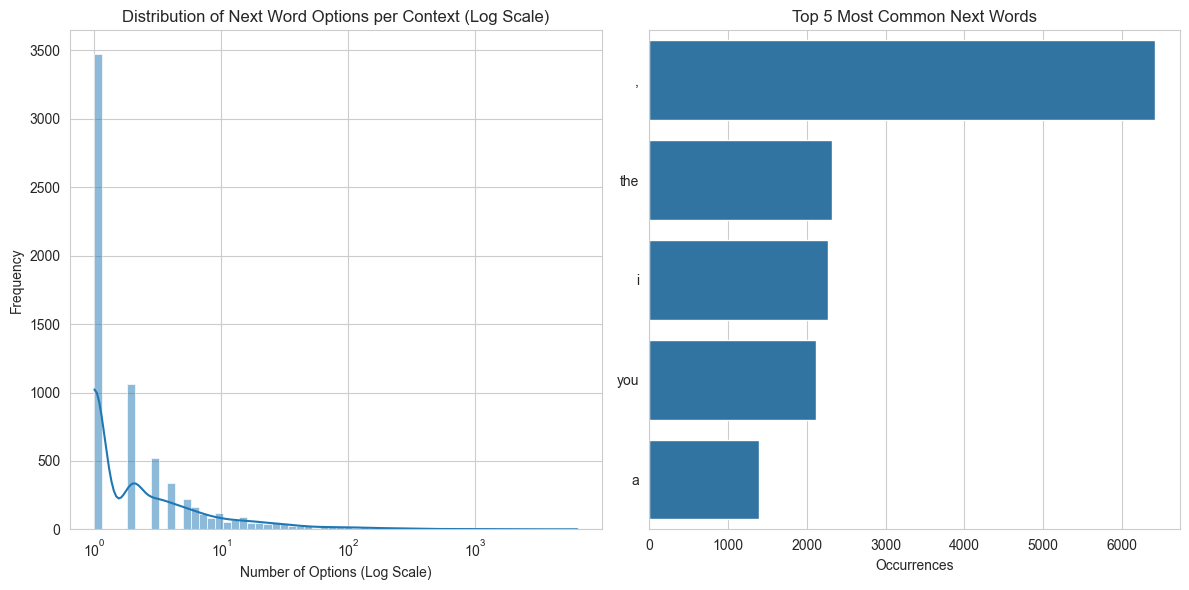

Model Analysis (Order 2):

Total contexts: 32420
Total next words: 70978
Average next words per context: 2.19

Top 5 contexts with most options:
', i' → 162 unique options
', you' → 104 unique options
', im' → 96 unique options
'in the' → 128 unique options
'me ,' → 60 unique options


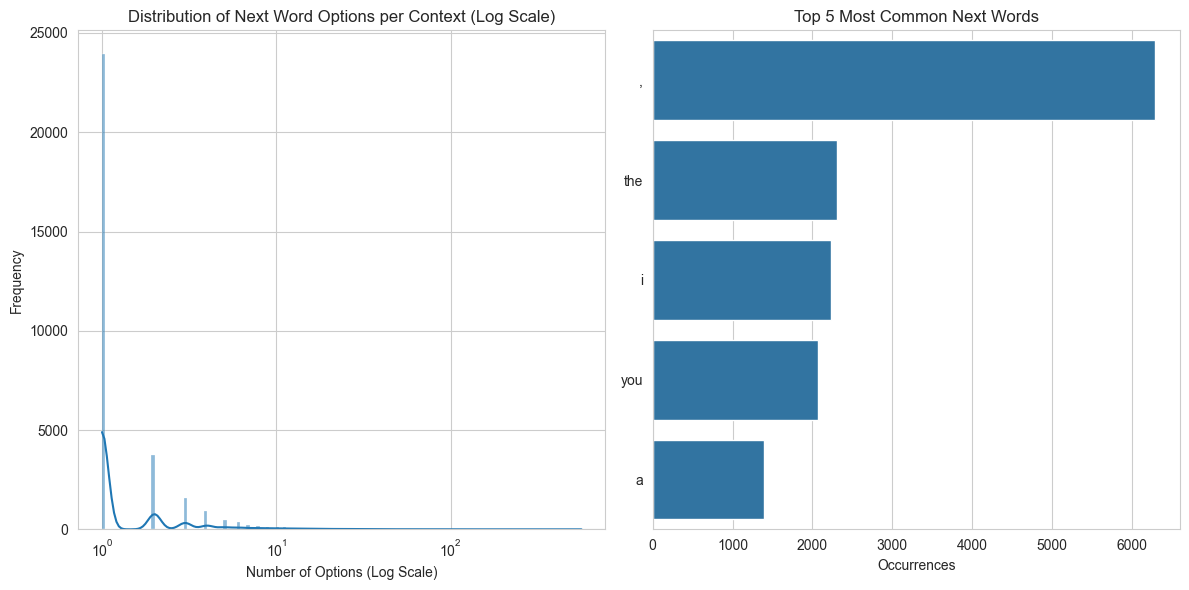

Model Analysis (Order 3):

Total contexts: 50712
Total next words: 70090
Average next words per context: 1.38

Top 5 contexts with most options:
'you might also' → 1 unique options
'might also like' → 56 unique options
'hol up ,' → 6 unique options
'cant please everybody' → 10 unique options
'i cant please' → 2 unique options


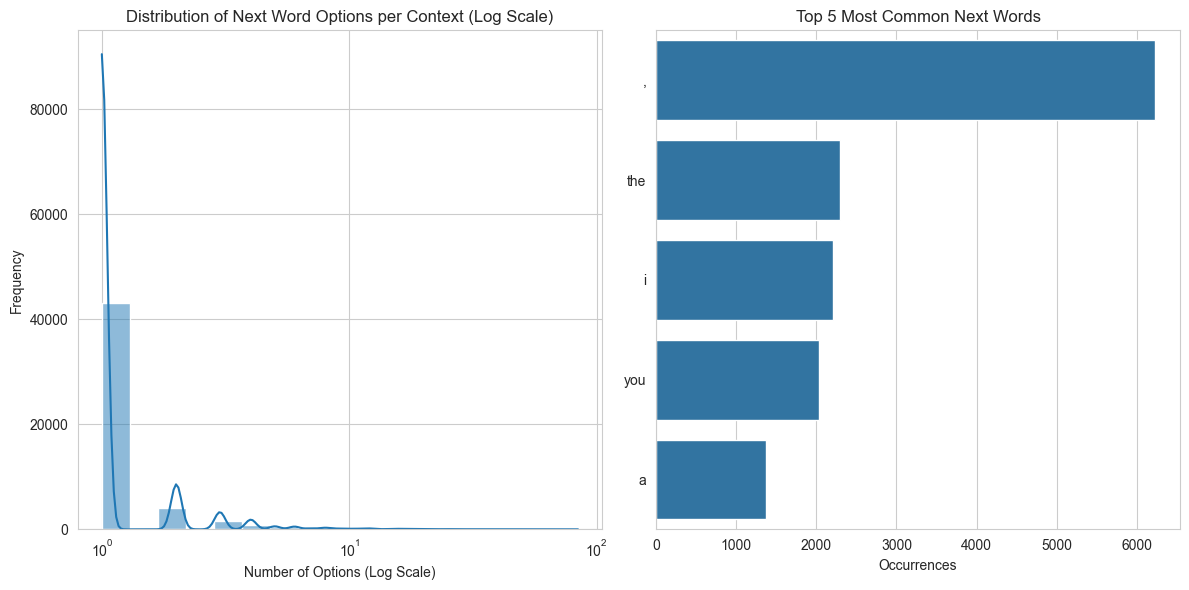

Model Analysis (Order 4):

Total contexts: 55411
Total next words: 69211
Average next words per context: 1.25

Top 5 contexts with most options:
'you might also like' → 56 unique options
'i cant please everybody' → 10 unique options
'hol up , hol' → 1 unique options
'up , hol up' → 7 unique options
'im real , im' → 2 unique options


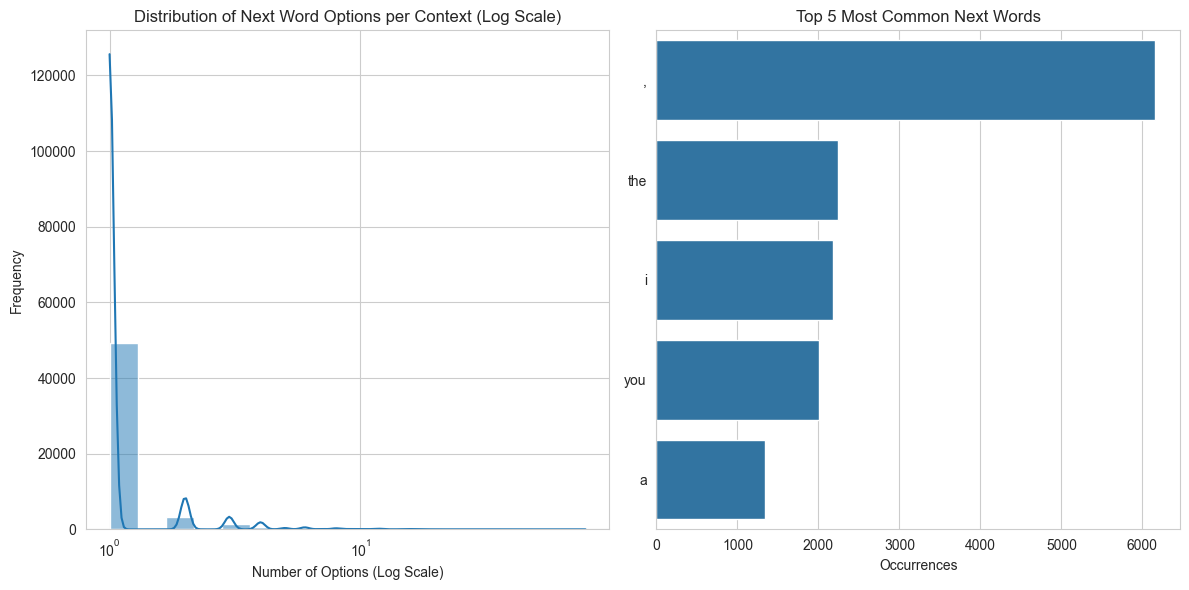

Model Analysis (Order 5):

Total contexts: 56379
Total next words: 68355
Average next words per context: 1.21

Top 5 contexts with most options:
'hol up , hol up' → 7 unique options
'i cant please everybody i' → 1 unique options
'cant please everybody i cant' → 1 unique options
'please everybody i cant please' → 1 unique options
'everybody i cant please everybody' → 5 unique options


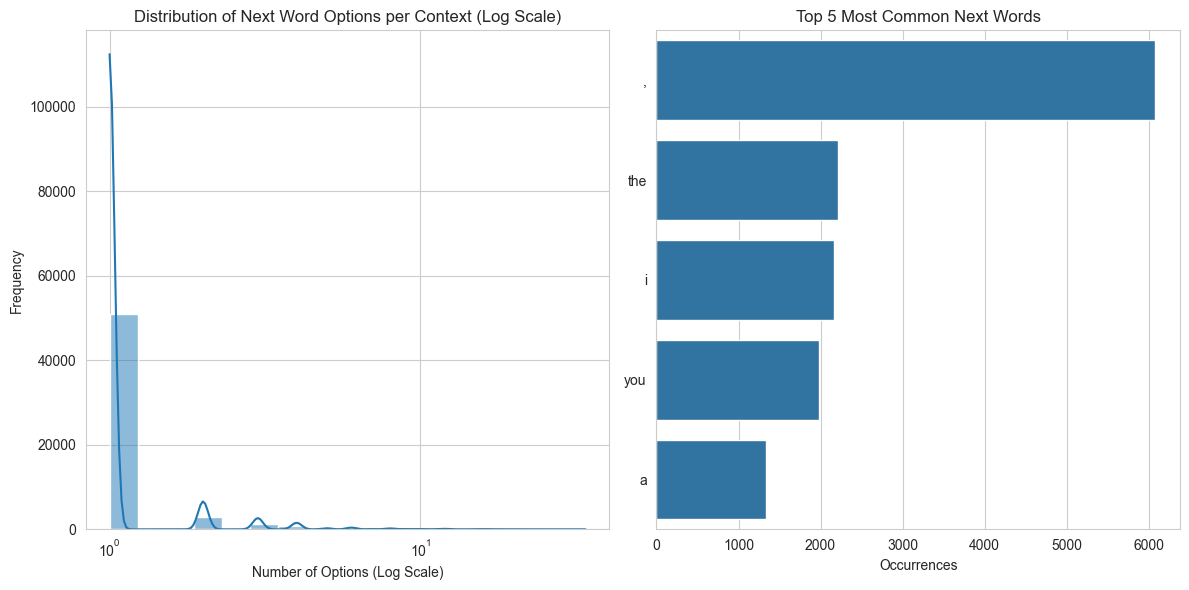

In [20]:
def analyze_model(model):
    """Analyze the Markov model and return insights."""
    if not model.model:
        return "Model is empty."
    
    # Count the number of contexts and next words
    context_count = len(model.model)
    next_word_count = sum(len(nexts) for nexts in model.model.values())
    avg_next_words = next_word_count / context_count
    
    # Find the contexts with the most options
    contexts_by_options = sorted(model.model.items(), key=lambda x: len(x[1]), reverse=True)
    top_contexts = contexts_by_options[:5]
    
    # Find the most common next words overall
    all_next_words = [word for words in model.model.values() for word in words]
    word_counts = {}
    for word in all_next_words:
        word_counts[word] = word_counts.get(word, 0) + 1
    top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    
    # Print the analysis
    print(f"Model Analysis (Order {model.order}):\n")
    print(f"Total contexts: {context_count}")
    print(f"Total next words: {next_word_count}")
    print(f"Average next words per context: {avg_next_words:.2f}")
    
    print("\nTop 5 contexts with most options:")
    for context, next_words in top_contexts:
        print(f"'{' '.join(context)}' → {len(set(next_words))} unique options")
    
    # Create visualizations
    plt.figure(figsize=(12, 6))
    
    # Distribution of next word options
    options_dist = [len(nexts) for nexts in model.model.values()]
    plt.subplot(1, 2, 1)
    # Apply logarithmic scale to the x-axis
    sns.histplot(options_dist, kde=True, log_scale=True) 
    plt.title("Distribution of Next Word Options per Context (Log Scale)")
    plt.xlabel("Number of Options (Log Scale)")
    plt.ylabel("Frequency")
    
    # Top words visualization
    plt.subplot(1, 2, 2)
    top_10_words = dict(top_words[:10])
    sns.barplot(x=list(top_10_words.values()), y=list(top_10_words.keys()))
    plt.title("Top 5 Most Common Next Words")
    plt.xlabel("Occurrences")
    
    plt.tight_layout()
    plt.show()

# Analyze the models if trained
if 'models' in locals() and models:
    for order, model in models.items():
        analyze_model(model)
else:
    print("Models not trained, cannot analyze.")